# Fourier Analysis Networks (FANs)

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [2]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# count how many trainable weights the model has
def count_parameters(model) -> None:
    total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Number of parameters: {total_params}')

# Building the FAN layer and a FAN model

Fourier Analysis is a mathematical way of breaking down functions into the frequencies that make them up. The analysis is based on the Fourier Series, which represents a periodic function as an infinite sum of sine and cosine terms:

$$
f_{\text{S}}(x) \triangleq a_0 + \sum_{n=1}^{N} \left( a_n \cos\left(\frac{2\pi nx}{T}\right) + b_n \sin\left(\frac{2\pi nx}{T}\right) \right)
$$

The coefficients a(n) and b(n) are calculated by integrating the function over one period. One of the best parts of the Fourier series is that it can even be extended to handle non-periodic functions. This is done using the Fourier transform that treats the non-periodic functions as if they were part of a signal with an infinitely large period ($T → ∞$), allowing us to break them into frequency components as well. While the Fourier series represents periodic functions as the sums of discrete frequencies, the Fourier Transform represents non-periodic functions as a continuous spectrum of frequencies.

To build a neural network from this, we first parameterize its coefficients as learnable weights and reformulate it to a vector representation:

$$
f_{\text{S}}(x) \triangleq B + W_\text{out}[\cos(W_\text{in}x)|| \sin(W_\text{in}x)]
$$

Instead of applying $f_\text{in}$ and $f_\text{out}$​ sequentially, we use both simultaneously to ensure that the intermediate layers contribute to periodicity modeling and refining the coefficients as well. This leads to the FAN layer $\phi(x)$ defined as:

$$
\phi(x) \triangleq [\cos(W_px)|| \sin(W_px)|| \sigma(B_{\bar{p}} + W_{\bar{p}}x)]
$$

In [4]:
class FANLayer(nn.Module):
    """
    The Fourier Analysis Network (FAN) layer.
    - gate (bool) defines a learnable "scalar‐gating" parameter g in (0, 1) that controls how much
    to use the periodic vs. non-periodic components.
    - Defined in https://arxiv.org/abs/2410.02675
    """

    def __init__(self, input_dim, output_dim, gate=True, bias=False) -> None:
        super(FANLayer, self).__init__()
        assert output_dim % 4 == 0, "output_dim must be divisible by 4"
        # p_output_dim is set to a quarter of output_dim as in the original paper
        p_output_dim    = output_dim // 4
        p_bar_output_dim= output_dim - p_output_dim * 2
        # Wp projects cosine and sine (periodic) components to a lower-dimensional space
        self.Wp= nn.Linear(input_dim, p_output_dim, bias=False)
        # if using gate, apply a (learnable scalar) gating parameter to balance the two branches
        if gate:
            self.gate= nn.Parameter(torch.randn(1))
            self.actv_fn= nn.SiLU()
        else:
            self.gate= None
            self.actv_fn= nn.GELU()
        # Wp_bar projects the non-periodic component
        self.Wp_bar= nn.Linear(input_dim, p_bar_output_dim, bias=bias)


    def forward(self, x):
        # compute the periodic cos/sin projection
        p    = self.Wp(x)                    # (B, T, p_output_dim)
        # compute the non‐periodic projection with activation
        p_bar= self.actv_fn(self.Wp_bar(x))  # (B, T, p_bar_output_dim)

        if self.gate is not None:
            # compute the gate value and modulate both branches
            g= torch.sigmoid(self.gate)      # scalar in (0, 1)
            return torch.cat((g * torch.cos(p), g * torch.sin(p), (1 - g) * p_bar), dim=-1)

        # concatenate the cosine, sine, and non-periodic components along the last dimension
        return torch.cat((torch.cos(p), torch.sin(p), p_bar), dim=-1)


The entire FAN is defined as the stacking of FAN layers $\phi(x)$:

$$
\text{FAN}(x) = \phi_L \circ  \phi_{L-1} \circ \cdots \circ \phi_{1} \circ x,
$$
where
$$
\small{
\phi_l(x) = \left\{
  \begin{array}{ll}
   [\cos(W^l_px)|| \sin(W^l_px)|| \sigma(B^l_{\bar{p}} + W^l_{\bar{p}}x)],&\text{if } l < L, \\
   B^L + W^Lx,&\text{if } l = L
  \end{array}
\right.}
$$

This neural network is called the Fourier Analysis Network or FAN.

**NOTE:** Gating Complexity -- If a single scalar gate is too limiting, we might experiment with a more flexible and complex gating design (e.g., a vector per token, allowing variation across both tokens and dimensions).

In [5]:
class FAN(nn.Module):
    """
    The FAN is defined as the stacking of FAN layers. The activation function is implemented in the
    FANLayer itself.
    """

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, gate=True, bias=True) -> None:
        super(FAN, self).__init__()
        # Implementation of FAN layers before the last layer
        self.layers= nn.ModuleList()
        for _ in range(num_layers - 1):
            self.layers.append(FANLayer(input_dim, hidden_dim, gate, bias))
            # Update input_dim after each layer to match the output of FANLayer
            input_dim= hidden_dim

        # Implementation of the final projection layer to the desired output_dim
        self.WL= nn.Linear(input_dim, output_dim, bias=bias)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                # normal_ presented the faster convergence
                nn.init.normal_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)


    def forward(self, x):
        for layer in self.layers:
            x= layer(x)

        return self.WL(x)


In [23]:
class FANFeedForward(nn.Module):
    """
    The Feed Forward Network (FFN) based on the FAN architecture. The activation function is
    implemented in the FANLayer itself.
    - nn.init.normal_ on this FAN network improves convergence.
    - This module can switch between a Gated-based FAN-FFN and a FAN-FFN on the glu flag.
    """

    def __init__(self, n_inputs, n_embed, d_ff, n_outputs, dropout=0.1, fan_gate=True, glu=True,
                 bias=True) -> None:
        super(FANFeedForward, self).__init__()

        # adapter layer to prepare the input to the FFN shape
        if n_inputs != n_embed:
            self.in_adapter= nn.Linear(n_inputs, n_embed, bias=bias)
        else:self.in_adapter= None

        # FAN up layer
        self.up_fan= FANLayer(n_embed, d_ff, fan_gate, bias=bias)
        # Gated Linear Unit (GLU) when glu=True
        if glu:
            #self.gate_proj= FANLayer(d_ff, d_ff, fan_gate, bias=bias)
            self.gate_proj= FANLayer(n_embed, d_ff, fan_gate, bias=bias)
        else:
            self.gate_proj= None
        # Dropout layer
        self.dropout= nn.Dropout(p=dropout) if dropout > 0.0 else None
        # FAN down layer
        self.down_fan= FANLayer(d_ff, n_embed, fan_gate, bias=bias)
        # Final projection when n_outputs is not None
        if n_outputs is not None and n_outputs != n_embed:
            self.WL= nn.Linear(n_embed, n_outputs, bias=bias)
        else:
            self.WL= None

        for m in self.modules():
            if isinstance(m, nn.Linear):
                # normal_ presented the faster convergence
                nn.init.normal_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)


    def forward(self, x):
        if self.in_adapter is not None:
            x= self.in_adapter(x)

        # apply GLU activation when glu=True
        if self.gate_proj is not None:
            #x= self.up_fan(x)
            #x= x * torch.sigmoid(self.gate_proj(x))
            x= self.up_fan(x) * torch.sigmoid(self.gate_proj(x))
        else:
            x= self.up_fan(x)
        if self.dropout is not None:
            x= self.dropout(x)
        x= self.down_fan(x)
        if self.WL is not None:
            x= self.WL(x)

        return x


# MLP model for comparison

The MLP neural network uses a simple linear transformation followed by a non-linear activation in each layer, the FAN integrates periodic transformations (sine and cosine) along with the non-linear activation.

FANs are based on the same theoretical concept that MLPs are based on, i.e. the Universal Approximation Theorem. However, they enhance MLPs by explicitly including periodicity in their architecture. This makes them more expressive than MLPs.

In [7]:
class MLPLayer(nn.Module):
    def __init__(self, input_dim, output_dim, bias=True) -> None:
        super(MLPLayer, self).__init__()
        self.linear= nn.Linear(input_dim, output_dim, bias=bias)
        self.activation= nn.GELU()

    def forward(self, x):
        return self.activation(self.linear(x))



class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bias=True):
        super(MLP, self).__init__()
        self.layers= nn.ModuleList()
        # Implementation of layers before the last layer
        for _ in range(num_layers - 1):
            self.layers.append(MLPLayer(input_dim, hidden_dim, bias))
            input_dim= hidden_dim

        # Implementation of the last layer
        self.layers.append(nn.Linear(hidden_dim, output_dim, bias=bias))

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)


    def forward(self, x):
        for layer in self.layers:
            x= layer(x)

        return x


# Training and Evaluation

Generate a dataset with samples obtained from a uniform distribution between 1 and 10 with added Gaussian noise, based on the equation below.

$$
y = \sin(2πx) + \cos(3πx)
$$

In [8]:
class SymbolicDataset(Dataset):
    def __init__(self, num_samples, noise_level):
        # Inputs obtained from sampling a uniform distribution
        self.x= np.random.uniform(0, 10, (num_samples, 1)).astype(np.float32)
        #Outputs calculated as per the periodic formula (shown above)
        self.y= (np.sin(2 * np.pi * self.x) + np.cos(3 * np.pi * self.x)).astype(np.float32)
        #Noise addition
        self.y += noise_level * np.random.randn(*self.y.shape).astype(np.float32)

    # Method that returns the number of samples in the dataset
    def __len__(self):
        return len(self.x)

    # Method that retrieves the sample at index 'idx'
    def __getitem__(self, idx):
        x= torch.from_numpy(self.x[idx])
        y= torch.from_numpy(self.y[idx])

        return x, y


In [9]:
def train_model(train_dataset, val_dataset, model, epochs, batch_size, lr, model_name):
    train_dataloader= DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader= DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Using the MSE loss
    criterion= nn.MSELoss()

    # Using the AdamW optimizer
    optimizer= torch.optim.AdamW(model.parameters(), lr=lr)

    train_losses= []
    val_losses= []

    for epoch in tqdm(range(1, epochs + 1), desc=f"Training {model_name}"):
        # Training phase
        model.train()
        epoch_train_loss= 0.0
        for x_batch, y_batch in train_dataloader:
            x_batch, y_batch= x_batch.to(device), y_batch.to(device)

            # Forward pass
            optimizer.zero_grad()
            preds= model(x_batch)
            loss= criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * x_batch.size(0)

        # Validation phase
        model.eval()
        epoch_val_loss= 0.0
        with torch.no_grad():
            for x_batch, y_batch in val_dataloader:
                x_batch, y_batch= x_batch.to(device), y_batch.to(device)
                preds= model(x_batch)
                loss= criterion(preds, y_batch)
                epoch_val_loss += loss.item() * x_batch.size(0)

        # Computing average losses
        epoch_train_loss /= len(train_dataset)
        epoch_val_loss /= len(val_dataset)
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        # Printing losses every 50 epochs
        if epoch % 50 == 0 or epoch == 1 or epoch == epochs:
            print(f"Epoch {epoch}/{epochs} - {model_name} Training Loss: {epoch_train_loss:.6f}, Validation Loss: {epoch_val_loss:.6f}")

    return train_losses, val_losses


In [10]:
def evaluate_model(fan_model, fan_gate_model, mlp_model):
    # Creating test dataset sampled evenly (compare it with training data)
    x_test= torch.linspace(0, 10, 1000).reshape(-1, 1).float().to(device)
    y_test= np.sin(2 * np.pi * x_test.cpu().numpy()) + np.cos(3 * np.pi * x_test.cpu().numpy())

    fan_model.eval()
    fan_gate_model.eval()
    mlp_model.eval()

    with torch.no_grad():
        fan_pred= fan_model(x_test).cpu().numpy()
        fan_gate_pred= fan_gate_model(x_test).cpu().numpy()
        mlp_pred= mlp_model(x_test).cpu().numpy()

    # Plotting the results
    plt.figure(figsize=(12, 6))

    plt.plot(x_test.cpu().numpy(), y_test, label="True Function", color="black", linestyle="dashed")
    plt.plot(x_test.cpu().numpy(), fan_pred, label="FAN Prediction", color="blue", alpha=0.7)
    plt.plot(x_test.cpu().numpy(), fan_gate_pred, label="FAN Gated Prediction", color="green", alpha=0.7)
    plt.plot(x_test.cpu().numpy(), mlp_pred, label="MLP Prediction", color="red", alpha=0.7)

    plt.legend()

    plt.title("Comparison of FAN, FAN Gated, and MLP on Symbolic Dataset")
    plt.xlabel("x")
    plt.ylabel("y")

    plt.show()


In [11]:
# Preparing dataset
dataset= SymbolicDataset(num_samples=1000, noise_level=0.1)

# Splitting dataset into training and validation sets
train_size= int(0.8 * len(dataset))
val_size= len(dataset) - train_size
train_dataset, val_dataset= torch.utils.data.random_split(dataset, [train_size, val_size])

In [ ]:
# Preparing models
mlp_model=      MLP(1, 32, 1, num_layers=3).to(device)
fan_model=      FAN(1, 32, 1, num_layers=3, gate=False).to(device)
fan_gate_model= FAN(1, 32, 1, num_layers=3, gate=True).to(device)

# Training the MLP model
print("\nStarting training for MLP model...")
mlp_train_losses, mlp_val_losses= train_model(
    train_dataset, val_dataset, mlp_model, epochs=500, batch_size=32, lr=0.001, model_name="MLP"
)

# Training the FAN model
print("\nStarting training for FAN model...")
fan_train_losses, fan_val_losses= train_model(
    train_dataset, val_dataset, fan_model, epochs=500, batch_size=32, lr=0.001, model_name="FAN"
)

# Training the FAN Gated model
print("\nStarting training for FAN Gated model...")
fang_train_losses, fang_val_losses= train_model(
    train_dataset, val_dataset, fan_gate_model, epochs=500, batch_size=32, lr=0.001, model_name="FAN"
)


Starting training for MLP model...


Training MLP:   0%|          | 2/500 [00:00<00:37, 13.33it/s]

Epoch 1/500 - MLP Training Loss: 6131.933398, Validation Loss: 4553.313262


Training MLP:  11%|█         | 54/500 [00:03<00:22, 20.14it/s]

Epoch 50/500 - MLP Training Loss: 0.943273, Validation Loss: 1.015490


Training MLP:  20%|██        | 102/500 [00:05<00:21, 18.67it/s]

Epoch 100/500 - MLP Training Loss: 0.922362, Validation Loss: 1.046327


Training MLP:  30%|███       | 152/500 [00:08<00:18, 18.49it/s]

Epoch 150/500 - MLP Training Loss: 0.912113, Validation Loss: 1.000620


Training MLP:  41%|████      | 203/500 [00:11<00:15, 19.23it/s]

Epoch 200/500 - MLP Training Loss: 0.893791, Validation Loss: 0.974652


Training MLP:  51%|█████     | 253/500 [00:14<00:15, 16.02it/s]

Epoch 250/500 - MLP Training Loss: 0.888583, Validation Loss: 0.950875


Training MLP:  61%|██████    | 304/500 [00:17<00:09, 20.19it/s]

Epoch 300/500 - MLP Training Loss: 0.871576, Validation Loss: 1.026107


Training MLP:  71%|███████   | 354/500 [00:19<00:07, 18.84it/s]

Epoch 350/500 - MLP Training Loss: 0.864229, Validation Loss: 0.913633


Training MLP:  80%|████████  | 402/500 [00:22<00:04, 20.00it/s]

Epoch 400/500 - MLP Training Loss: 0.855662, Validation Loss: 0.887818


Training MLP:  90%|█████████ | 452/500 [00:25<00:03, 14.16it/s]

Epoch 450/500 - MLP Training Loss: 0.833421, Validation Loss: 0.849053


Training MLP: 100%|██████████| 500/500 [00:28<00:00, 17.83it/s]


Epoch 500/500 - MLP Training Loss: 0.846348, Validation Loss: 0.833044

Starting training for FAN model...


Training FAN:   0%|          | 2/500 [00:00<00:37, 13.26it/s]

Epoch 1/500 - FAN Training Loss: 1603.460552, Validation Loss: 805.344265


Training FAN:  10%|█         | 52/500 [00:03<00:31, 14.21it/s]

Epoch 50/500 - FAN Training Loss: 0.640952, Validation Loss: 0.785266


Training FAN:  20%|██        | 102/500 [00:07<00:29, 13.71it/s]

Epoch 100/500 - FAN Training Loss: 0.219011, Validation Loss: 0.243799


Training FAN:  30%|███       | 151/500 [00:11<00:32, 10.68it/s]

Epoch 150/500 - FAN Training Loss: 0.101708, Validation Loss: 0.107466


Training FAN:  40%|████      | 201/500 [00:15<00:21, 13.71it/s]

Epoch 200/500 - FAN Training Loss: 0.048907, Validation Loss: 0.053980


Training FAN:  50%|█████     | 251/500 [00:19<00:17, 13.87it/s]

Epoch 250/500 - FAN Training Loss: 0.031626, Validation Loss: 0.034633


Training FAN:  60%|██████    | 301/500 [00:23<00:19, 10.32it/s]

Epoch 300/500 - FAN Training Loss: 0.023257, Validation Loss: 0.025179


Training FAN:  70%|███████   | 352/500 [00:27<00:10, 13.77it/s]

Epoch 350/500 - FAN Training Loss: 0.017886, Validation Loss: 0.018912


Training FAN:  80%|████████  | 402/500 [00:30<00:06, 14.40it/s]

Epoch 400/500 - FAN Training Loss: 0.021929, Validation Loss: 0.019357


Training FAN:  90%|█████████ | 450/500 [00:34<00:03, 13.52it/s]

Epoch 450/500 - FAN Training Loss: 0.022924, Validation Loss: 0.016992


Training FAN: 100%|██████████| 500/500 [00:39<00:00, 12.81it/s]


Epoch 500/500 - FAN Training Loss: 0.023542, Validation Loss: 0.028551

Starting training for FAN Gated model...


Training FAN:   0%|          | 2/500 [00:00<00:38, 13.03it/s]

Epoch 1/500 - FAN Training Loss: 53.193000, Validation Loss: 19.222632


Training FAN:  10%|█         | 52/500 [00:03<00:34, 13.01it/s]

Epoch 50/500 - FAN Training Loss: 0.518132, Validation Loss: 0.566397


Training FAN:  20%|██        | 102/500 [00:07<00:29, 13.45it/s]

Epoch 100/500 - FAN Training Loss: 0.369147, Validation Loss: 0.416174


Training FAN:  30%|███       | 152/500 [00:12<00:27, 12.62it/s]

Epoch 150/500 - FAN Training Loss: 0.229164, Validation Loss: 0.227619


Training FAN:  40%|████      | 202/500 [00:16<00:22, 13.24it/s]

Epoch 200/500 - FAN Training Loss: 0.108472, Validation Loss: 0.101336


Training FAN:  50%|█████     | 252/500 [00:20<00:19, 12.84it/s]

Epoch 250/500 - FAN Training Loss: 0.054885, Validation Loss: 0.061371


Training FAN:  60%|██████    | 302/500 [00:25<00:15, 12.86it/s]

Epoch 300/500 - FAN Training Loss: 0.030398, Validation Loss: 0.030260


Training FAN:  70%|███████   | 352/500 [00:29<00:11, 13.26it/s]

Epoch 350/500 - FAN Training Loss: 0.023983, Validation Loss: 0.025344


Training FAN:  80%|████████  | 402/500 [00:33<00:07, 13.16it/s]

Epoch 400/500 - FAN Training Loss: 0.016841, Validation Loss: 0.015733


Training FAN:  90%|█████████ | 451/500 [00:38<00:03, 12.65it/s]

Epoch 450/500 - FAN Training Loss: 0.017854, Validation Loss: 0.015573


Training FAN: 100%|██████████| 500/500 [00:41<00:00, 11.92it/s]

Epoch 500/500 - FAN Training Loss: 0.012977, Validation Loss: 0.012883


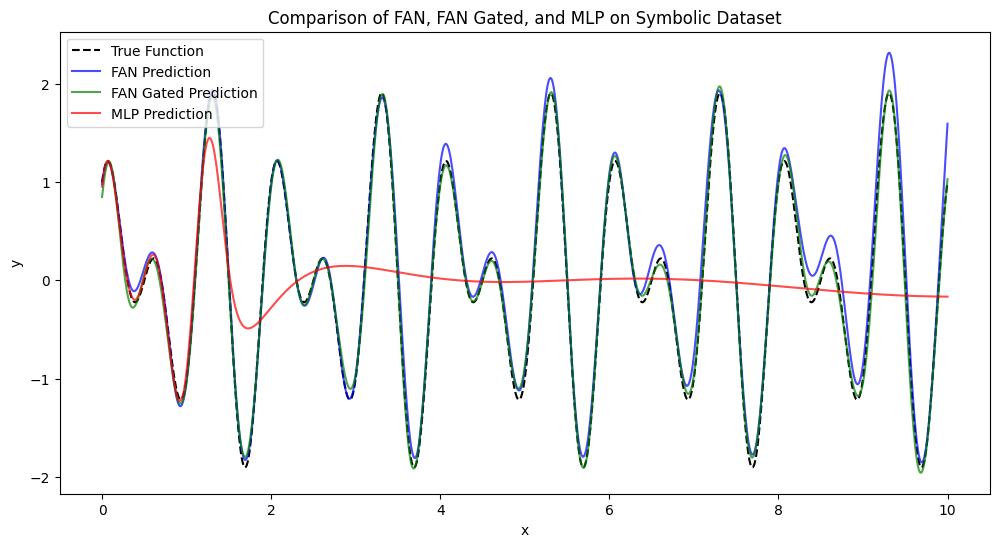

In [ ]:
# Using the evaluation function to plot results
evaluate_model(fan_model, fan_gate_model, mlp_model)

In [24]:
# Evaluating the FFN implementations
# ----- GLU False -----
fan_model=      FANFeedForward(1, 32, 64, 1, dropout=0.1, fan_gate=False, glu=False).to(device)
fan_gate_model= FANFeedForward(1, 32, 64, 1, dropout=0.1, fan_gate=True,  glu=False).to(device)

# Training the FAN model
print("\nStarting training for FAN model...")
fan_train_losses, fan_val_losses= train_model(
    train_dataset, val_dataset, fan_model, epochs=500, batch_size=32, lr=0.001, model_name="FAN"
)

# Training the FAN Gated model
print("\nStarting training for FAN Gated model...")
fang_train_losses, fang_val_losses= train_model(
    train_dataset, val_dataset, fan_gate_model, epochs=500, batch_size=32, lr=0.001, model_name="FAN"
)

# ----- GLU True -----
fan_glu_model=      FANFeedForward(1, 32, 64, 1, dropout=0.1, fan_gate=False, glu=True).to(device)
fan_gate_glu_model= FANFeedForward(1, 32, 64, 1, dropout=0.1, fan_gate=True,  glu=True).to(device)

# Training the FAN model
print("\nStarting training for FAN GLU model...")
fan_train_losses, fan_val_losses= train_model(
    train_dataset, val_dataset, fan_glu_model, epochs=500, batch_size=32, lr=0.001, model_name="FAN"
)

# Training the FAN Gated model
print("\nStarting training for FAN Gated GLU model...")
fang_train_losses, fang_val_losses= train_model(
    train_dataset, val_dataset, fan_gate_glu_model, epochs=500, batch_size=32, lr=0.001, model_name="FAN"
)


Starting training for FAN model...


Training FAN:   0%|          | 1/500 [00:00<00:56,  8.82it/s]

Epoch 1/500 - FAN Training Loss: 19069.682793, Validation Loss: 202.487183


Training FAN:  10%|█         | 51/500 [00:04<00:33, 13.48it/s]

Epoch 50/500 - FAN Training Loss: 162.177151, Validation Loss: 27.589827


Training FAN:  20%|██        | 101/500 [00:07<00:27, 14.72it/s]

Epoch 100/500 - FAN Training Loss: 48.110522, Validation Loss: 4.867617


Training FAN:  30%|███       | 151/500 [00:11<00:28, 12.25it/s]

Epoch 150/500 - FAN Training Loss: 16.921576, Validation Loss: 2.724481


Training FAN:  41%|████      | 203/500 [00:15<00:21, 14.05it/s]

Epoch 200/500 - FAN Training Loss: 7.409855, Validation Loss: 1.589838


Training FAN:  51%|█████     | 253/500 [00:18<00:16, 15.37it/s]

Epoch 250/500 - FAN Training Loss: 3.122219, Validation Loss: 0.651037


Training FAN:  60%|██████    | 301/500 [00:22<00:13, 14.83it/s]

Epoch 300/500 - FAN Training Loss: 1.508274, Validation Loss: 0.170393


Training FAN:  70%|███████   | 351/500 [00:25<00:13, 11.13it/s]

Epoch 350/500 - FAN Training Loss: 1.466252, Validation Loss: 0.142552


Training FAN:  81%|████████  | 403/500 [00:30<00:06, 15.02it/s]

Epoch 400/500 - FAN Training Loss: 0.554440, Validation Loss: 0.050224


Training FAN:  91%|█████████ | 453/500 [00:33<00:03, 14.86it/s]

Epoch 450/500 - FAN Training Loss: 0.662721, Validation Loss: 0.039118


Training FAN: 100%|██████████| 500/500 [00:37<00:00, 13.43it/s]


Epoch 500/500 - FAN Training Loss: 0.359176, Validation Loss: 0.214412

Starting training for FAN Gated model...


Training FAN:   0%|          | 2/500 [00:00<00:34, 14.27it/s]

Epoch 1/500 - FAN Training Loss: 27262.154453, Validation Loss: 14435.995176


Training FAN:  10%|█         | 52/500 [00:04<00:31, 14.19it/s]

Epoch 50/500 - FAN Training Loss: 70.026466, Validation Loss: 3.853864


Training FAN:  20%|██        | 102/500 [00:08<00:28, 14.02it/s]

Epoch 100/500 - FAN Training Loss: 10.792626, Validation Loss: 2.626536


Training FAN:  30%|███       | 152/500 [00:11<00:31, 11.22it/s]

Epoch 150/500 - FAN Training Loss: 2.729061, Validation Loss: 1.521006


Training FAN:  40%|████      | 201/500 [00:16<00:22, 13.50it/s]

Epoch 200/500 - FAN Training Loss: 1.837970, Validation Loss: 1.049542


Training FAN:  50%|█████     | 251/500 [00:19<00:18, 13.67it/s]

Epoch 250/500 - FAN Training Loss: 1.231949, Validation Loss: 0.565333


Training FAN:  60%|██████    | 301/500 [00:23<00:13, 14.34it/s]

Epoch 300/500 - FAN Training Loss: 1.118584, Validation Loss: 0.407501


Training FAN:  70%|███████   | 352/500 [00:27<00:13, 10.58it/s]

Epoch 350/500 - FAN Training Loss: 0.672679, Validation Loss: 0.292985


Training FAN:  80%|████████  | 402/500 [00:31<00:08, 11.02it/s]

Epoch 400/500 - FAN Training Loss: 0.597306, Validation Loss: 0.284541


Training FAN:  90%|█████████ | 452/500 [00:35<00:03, 14.31it/s]

Epoch 450/500 - FAN Training Loss: 0.434616, Validation Loss: 0.320952


Training FAN: 100%|██████████| 500/500 [00:39<00:00, 12.66it/s]


Epoch 500/500 - FAN Training Loss: 0.395788, Validation Loss: 0.337016

Starting training for FAN GLU model...


Training FAN:   0%|          | 1/500 [00:00<01:05,  7.62it/s]

Epoch 1/500 - FAN Training Loss: 4438.064072, Validation Loss: 73.335672


Training FAN:  10%|█         | 52/500 [00:04<00:37, 11.87it/s]

Epoch 50/500 - FAN Training Loss: 32.927374, Validation Loss: 7.442212


Training FAN:  20%|██        | 102/500 [00:09<00:32, 12.16it/s]

Epoch 100/500 - FAN Training Loss: 11.274793, Validation Loss: 2.595253


Training FAN:  30%|███       | 152/500 [00:14<00:29, 11.61it/s]

Epoch 150/500 - FAN Training Loss: 5.927926, Validation Loss: 0.892572


Training FAN:  40%|████      | 202/500 [00:18<00:24, 12.39it/s]

Epoch 200/500 - FAN Training Loss: 2.399984, Validation Loss: 0.283406


Training FAN:  50%|█████     | 252/500 [00:22<00:20, 11.97it/s]

Epoch 250/500 - FAN Training Loss: 1.840944, Validation Loss: 0.110432


Training FAN:  60%|██████    | 302/500 [00:27<00:17, 11.24it/s]

Epoch 300/500 - FAN Training Loss: 0.892283, Validation Loss: 0.101648


Training FAN:  70%|███████   | 352/500 [00:31<00:12, 12.18it/s]

Epoch 350/500 - FAN Training Loss: 0.415545, Validation Loss: 0.069460


Training FAN:  80%|████████  | 400/500 [00:35<00:08, 11.89it/s]

Epoch 400/500 - FAN Training Loss: 0.249619, Validation Loss: 0.128646


Training FAN:  90%|█████████ | 452/500 [00:40<00:04, 12.00it/s]

Epoch 450/500 - FAN Training Loss: 0.243229, Validation Loss: 0.071191


Training FAN: 100%|██████████| 500/500 [00:45<00:00, 11.08it/s]


Epoch 500/500 - FAN Training Loss: 0.148129, Validation Loss: 0.066682

Starting training for FAN Gated GLU model...


Training FAN:   0%|          | 2/500 [00:00<00:43, 11.49it/s]

Epoch 1/500 - FAN Training Loss: 18359.083906, Validation Loss: 4002.173223


Training FAN:  10%|█         | 51/500 [00:05<00:53,  8.37it/s]

Epoch 50/500 - FAN Training Loss: 63.326848, Validation Loss: 12.319479


Training FAN:  20%|██        | 101/500 [00:10<00:38, 10.47it/s]

Epoch 100/500 - FAN Training Loss: 15.634346, Validation Loss: 1.118280


Training FAN:  30%|███       | 151/500 [00:15<00:32, 10.85it/s]

Epoch 150/500 - FAN Training Loss: 6.416206, Validation Loss: 0.458694


Training FAN:  40%|████      | 202/500 [00:20<00:27, 10.94it/s]

Epoch 200/500 - FAN Training Loss: 3.053332, Validation Loss: 0.342531


Training FAN:  50%|█████     | 251/500 [00:25<00:23, 10.61it/s]

Epoch 250/500 - FAN Training Loss: 1.398209, Validation Loss: 0.237627


Training FAN:  60%|██████    | 302/500 [00:30<00:23,  8.51it/s]

Epoch 300/500 - FAN Training Loss: 0.830170, Validation Loss: 0.133429


Training FAN:  70%|███████   | 351/500 [00:35<00:13, 11.13it/s]

Epoch 350/500 - FAN Training Loss: 0.736962, Validation Loss: 0.335663


Training FAN:  80%|████████  | 402/500 [00:40<00:08, 10.92it/s]

Epoch 400/500 - FAN Training Loss: 0.337860, Validation Loss: 0.126506


Training FAN:  90%|█████████ | 452/500 [00:45<00:04, 10.89it/s]

Epoch 450/500 - FAN Training Loss: 0.187819, Validation Loss: 0.073243


Training FAN: 100%|██████████| 500/500 [00:49<00:00, 10.03it/s]

Epoch 500/500 - FAN Training Loss: 0.110003, Validation Loss: 0.040697


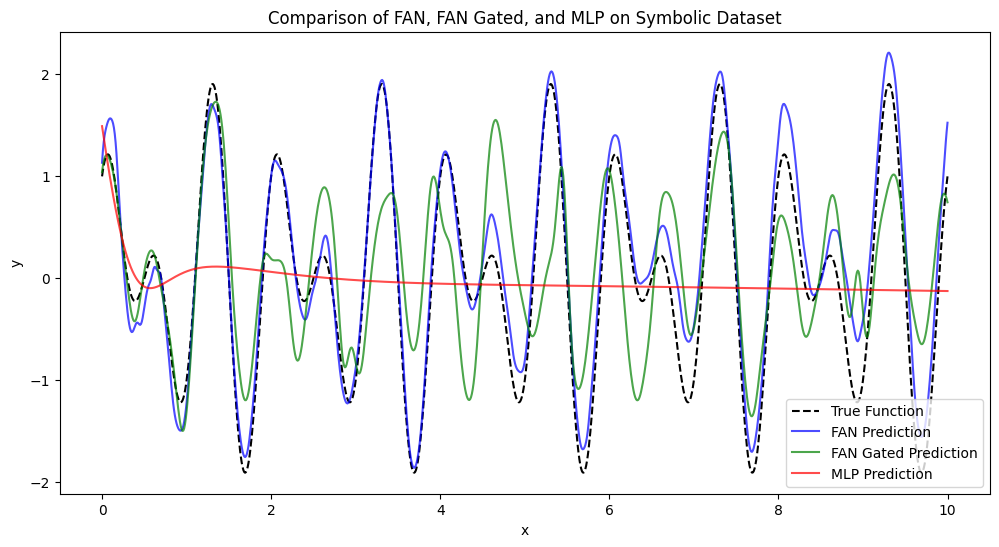

In [18]:
# Using the evaluation function to plot results
evaluate_model(fan_model, fan_gate_model, mlp_model)

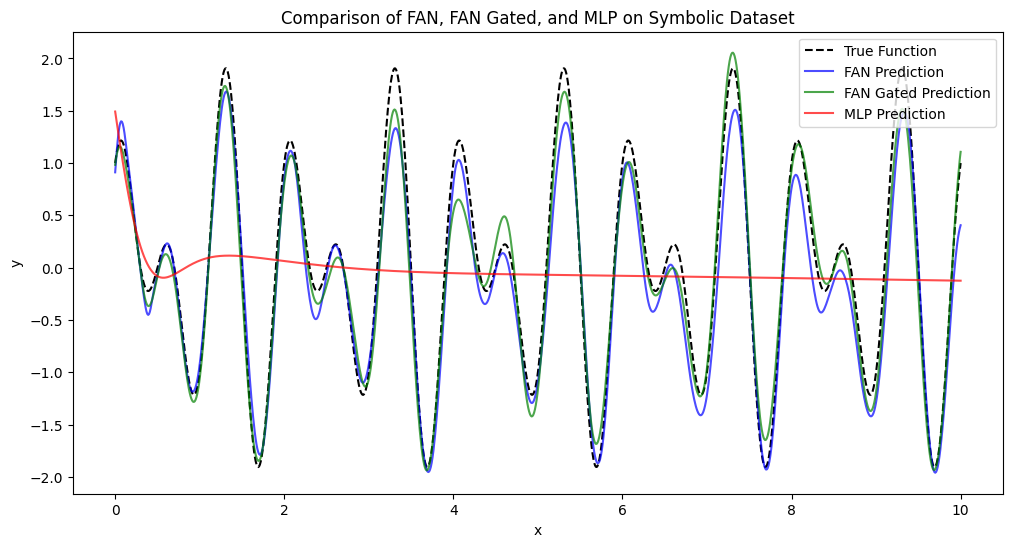

In [27]:
# ----- Gating from the Raw Input (Llama-like) -----
# Using the evaluation function to plot results
evaluate_model(fan_glu_model, fan_gate_glu_model, mlp_model)

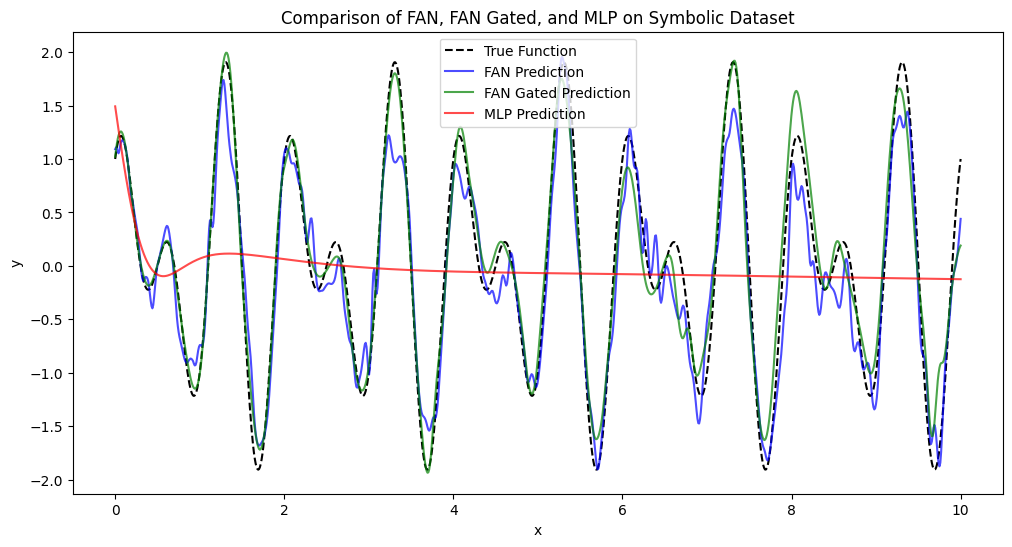

In [19]:
# ----- Gating from the "Post‐FAN" Output -----
# Using the evaluation function to plot results
evaluate_model(fan_glu_model, fan_gate_glu_model, mlp_model)

In [ ]:
# https://github.com/YihongDong/FAN/
# https://github.com/YihongDong/FAN/blob/main/Timeseries_Forecasting/layers/Transformer_EncDec.py
# https://levelup.gitconnected.com/fourier-analysis-networks-fans-are-here-to-break-barriers-in-ai-1c521c6656bc